In [1]:
import os 
import cv2 
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
import keras
import tensorflow as tf

2024-03-28 04:19:54.402536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 04:19:54.402673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 04:19:54.563077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Read Data

In [2]:
furits="/kaggle/input/fruits-dataset-for-classification"
os.listdir(furits)


['rotten_peaches_done',
 'fresh_strawberries_done',
 'fresh_peaches_done',
 'rotten_pomegranates_done',
 'fresh_pomegranates_done',
 'rotten_strawberries_done']

In [3]:
images=[]
labels=[]
for i,file in  enumerate(os.listdir(furits)):
    for img in os.listdir(os.path.join(furits,file)):
        im=(os.path.join(furits,file,img))
        images.append(im)
        labels.append(i)
        
        

### chek data balance

In [4]:
class_title={0:'fresh_peaches_done',
             1:'fresh_pomegranates_done',
             2:'fresh_strawberries_done',
             3:'rotten_peaches_done',
             4:'rotten_pomegranates_done',
             5:'rotten_strawberries_done'}

In [5]:
result=[]
for i in range(6):
    result.append({"label":class_title[i],"count":labels.count(i)})


<Axes: ylabel='count'>

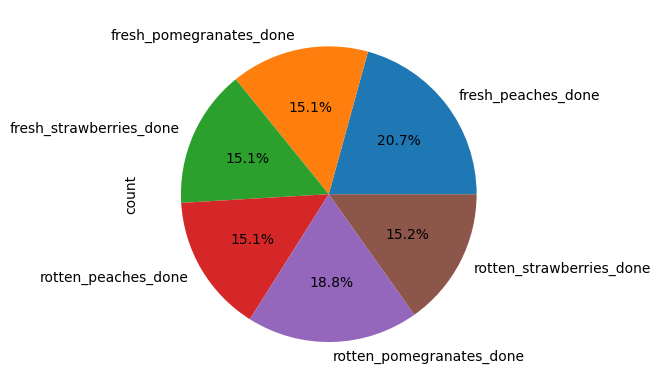

In [6]:
df=pd.DataFrame(result)
df["count"].plot(kind="pie",labels=df['label'].values,autopct='%1.1f%%')

In [7]:
from sklearn.utils import resample
import pandas as pd

min_class =min(labels.count(i) for i in range(6))
balance_labels=[]
balance_images=[]

for i in range(6):
    class_indices=[index for index,label in enumerate(labels) if label ==i]
    balanced_indices=resample(class_indices,replace=True,n_samples=min_class,random_state=42)
    balance_labels.extend([labels[index] for index in balanced_indices])
    balance_images.extend([images[index] for index in balanced_indices])

### display data after balanced

<Axes: ylabel='count_balanced'>

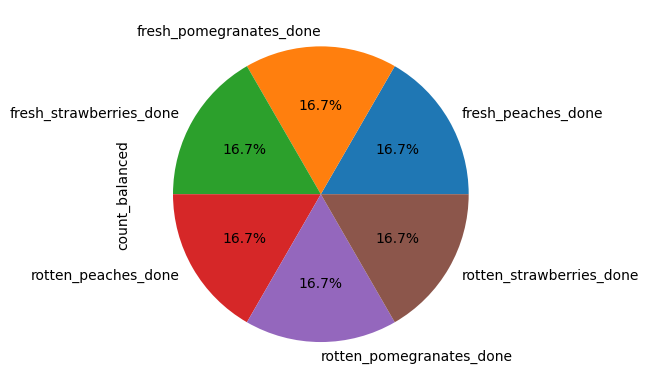

In [8]:
result_balanced=[]
for i in range(6):
    result_balanced.append({"label_balanced":class_title[i],"count_balanced":balance_labels.count(i)})

df_balanced=pd.DataFrame(result_balanced)
df_balanced["count_balanced"].plot(kind="pie",labels=df_balanced['label_balanced'].values,autopct='%1.1f%%')

### Split Data

In [9]:
x_train,x_test,y_train,y_test=train_test_split(balance_images,balance_labels,test_size=0.2,random_state=42)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [11]:
# class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
# class_weights_dict=dict(enumerate(class_weights))

In [12]:
y_train=list(map(str,y_train))
y_test=list(map(str,y_test))

### Data agumention

In [13]:

train_datagen=ImageDataGenerator(
    
                        rescale=1./255.0,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                )

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_genertor=train_datagen.flow_from_dataframe(
    
                    dataframe=pd.DataFrame({'imgs':x_train,'labels':y_train}),
                    x_col='imgs'
                    ,y_col='labels',
                    target_size=(224,224),
                    class_mode="categorical",
                    shuffle=False,
                    batch_size=64,
                )


test_genertor=test_datagen.flow_from_dataframe(
                    dataframe=pd.DataFrame({'imgs':x_test,'labels':y_test}),
                     x_col='imgs'
                    ,y_col='labels',
                    target_size=(224,224),
                    class_mode="categorical",
                    shuffle=False,
                    batch_size=64,
                )

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


### Display some of images

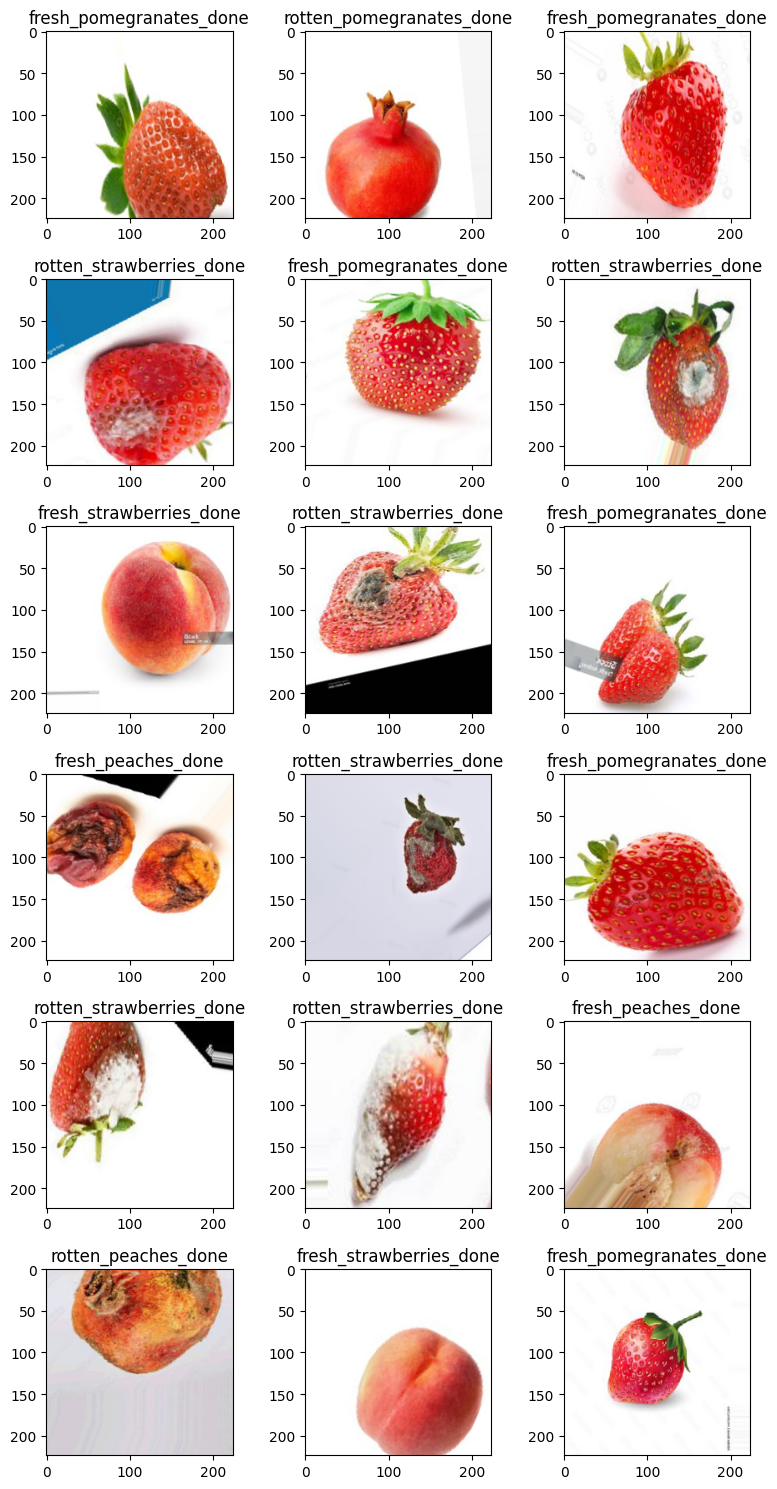

In [14]:



fig,ax=plt.subplots(6,3,figsize=(8,15))
classes=list(range(6))

for class_idx in classes:
    for i in range(3):
        img,label=next(train_genertor)
        for idx,val in enumerate(label[0]):
            if val==1:
                x=idx
                break
        ax[class_idx,i].imshow(img[0])
        ax[class_idx,i].set_title(class_title[x])
plt.tight_layout()
plt.show()        

### Bulid model structure

In [15]:
Model=VGG16(include_top=False,weights='imagenet',pooling='avg',input_shape=(224,224,3))

for layer in Model.layers:
   layer.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model=keras.Sequential()
model.add(Model)
model.add(keras.layers.Dense(256,activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(6,activation="softmax"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
loss=keras.losses.CategoricalCrossentropy(),
metrics=["accuracy"],
)

In [18]:
history = model.fit(train_genertor,validation_data=test_genertor,verbose=2,epochs=30,steps_per_epoch=len(train_genertor.classes)//64)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1711599699.539358      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711599699.559530      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711599752.329093      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711599755.314624      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 - 162s - 9s/step - accuracy: 0.2042 - loss: 1.8677 - val_accuracy: 0.4567 - val_loss: 1.6622
Epoch 2/30


W0000 00:00:1711599796.418722      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 - 2s - 89ms/step - accuracy: 0.2031 - loss: 1.8181 - val_accuracy: 0.4667 - val_loss: 1.6586
Epoch 3/30
18/18 - 17s - 929ms/step - accuracy: 0.2975 - loss: 1.6322 - val_accuracy: 0.5167 - val_loss: 1.4407
Epoch 4/30
18/18 - 2s - 86ms/step - accuracy: 0.3438 - loss: 1.5617 - val_accuracy: 0.4967 - val_loss: 1.4267
Epoch 5/30
18/18 - 17s - 932ms/step - accuracy: 0.4208 - loss: 1.4412 - val_accuracy: 0.5700 - val_loss: 1.2042
Epoch 6/30
18/18 - 2s - 86ms/step - accuracy: 0.4219 - loss: 1.3352 - val_accuracy: 0.5600 - val_loss: 1.1963
Epoch 7/30
18/18 - 17s - 926ms/step - accuracy: 0.4965 - loss: 1.2372 - val_accuracy: 0.6867 - val_loss: 0.9965
Epoch 8/30
18/18 - 2s - 86ms/step - accuracy: 0.4844 - loss: 1.1496 - val_accuracy: 0.6833 - val_loss: 0.9935
Epoch 9/30
18/18 - 17s - 918ms/step - accuracy: 0.5546 - loss: 1.1275 - val_accuracy: 0.6900 - val_loss: 0.8955
Epoch 10/30
18/18 - 2s - 85ms/step - accuracy: 0.5625 - loss: 1.0712 - val_accuracy: 0.7000 - val_loss: 0.8862
Epoch 11/30


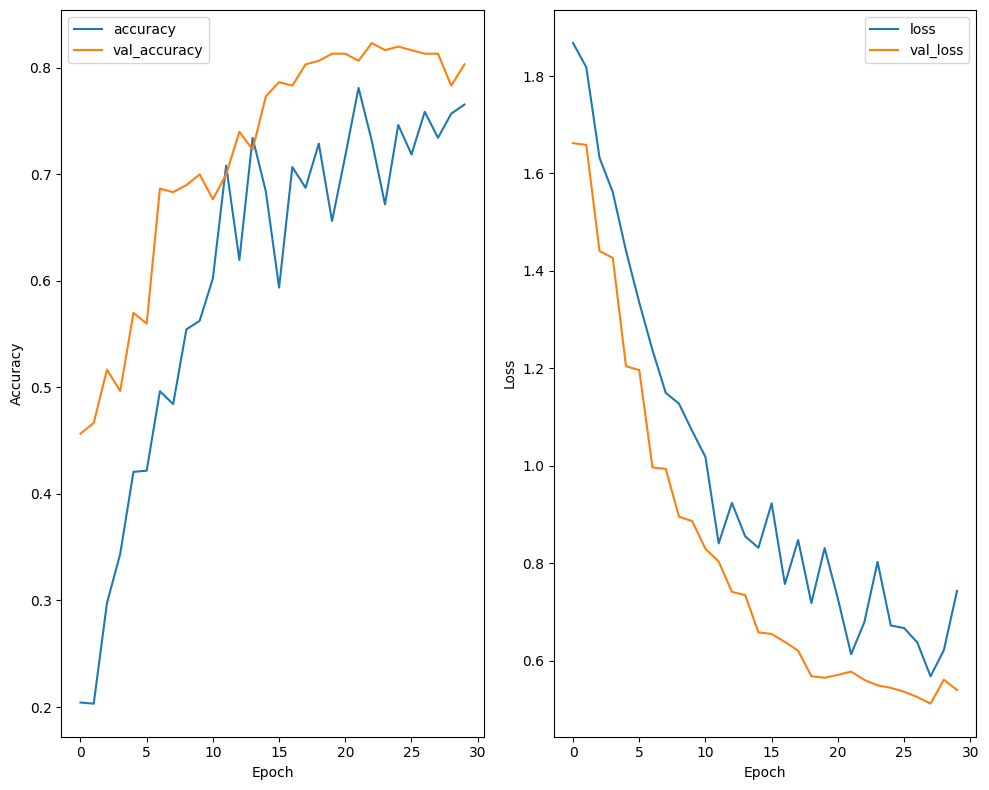

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10, 8))

ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()